# EDA

In [2]:
!pip install plotly


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install boto3==1.19.12
!pip install s3fs


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


#### Imports

In [4]:
# General
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
import numpy as np
import xlsxwriter
import datetime
import boto3


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Warnings
import warnings
warnings.filterwarnings("ignore")

#### Paths

In [5]:
dir_plots = '../plots/'
dir_reports = '../reports/'
dir_save_s3 = "s3://iberia-data-lake/customer/churn/churn_data_features/part-00000-98cf52a7-afaa-4220-986a-ae1177f2ef5c-c000.csv"
dir_save_s3 = "s3://iberia-data-lake/customer/churn/churn_data_features_all_17032022/part-00000-956a8369-63ca-414d-aa8f-8fa01d2b8e71-c000.snappy.orc"
dir_save_s3 = "s3://iberia-data-lake/customer/churn/churn_data_features_all_extra_12032022/part-00000-fdd04dac-9fd8-4859-9349-3bfb0da4afb4-c000.snappy.orc"

#### Functions

In [6]:
def compare_years_transf(row, thrs, col1, col2):

    if (row[col2]) == 0 and row[col1] > 0:
        return 'GROWER'
    change = (row[col1] - (row[col2]))/(row[col2])
    if change > thrs:
        return 'GROWER'
    elif change < -thrs:
        return 'LOWER'
    else:
        return 'MANTAINER'
    
def extract_value_customer(row, col):

    if row[col] < 500:
        return 'LOW'
    elif row[col] > 1000:
        return 'HIGH'
    else:
        return 'MID'

def predict_model(model, X):
    
    y_pred = model.predict(X)
    y_pred[y_pred < 0] = 0
    
    return y_pred

def compute_custom_mae(x):
    
    try:
        return abs(x['gross_revenue_future'] - x['prediction'])/x['gross_revenue_future']
    except: 
        if x['prediction'] < 50: # If future zero and prediction less than 50
            return 0
        else:
            return 1

def plot_metrics(dict_metrics, dict_dfs, dir_plots):

    print('---------------------------------------------------------------')
    print('------------------------GENERAL METRICS------------------------')
    print('---------------------------------------------------------------\n\n')
    print('MAE Train: ' + str(dict_metrics['MAE Train']))
    print('MAE: ' + str(dict_metrics['MAE']))
    print('RMSE: ' + str(dict_metrics['RMSE']))
    print('MSE: ' + str(dict_metrics['MSE']))
    print('Accuracy: ' + str(dict_metrics['Accuracy']) + '\n')
    print('R2: ' + str(dict_metrics['R2']) + '\n')

    print('---------------------------------------------------------------')
    print('----------------------INDIVIDUAL METRICS-----------------------')
    print('---------------------------------------------------------------\n\n')

    print('---------GROWERS----------\n')
    print('Accuracy: ' + str(dict_metrics['Growers Accuracy']))
    print('MAE: ' + str(dict_metrics['Growers MAE']))
    print('RMSE: ' + str(dict_metrics['Growers RMSE']))
    print('MSE: ' + str(dict_metrics['Growers MSE']) + '\n')

    print('----------MANTAINERS----------\n')
    print('Accuracy: ' + str(dict_metrics['Mantainers Accuracy']))
    print('MAE: ' + str(dict_metrics['Mantainers MAE']))
    print('RMSE: ' + str(dict_metrics['Mantainers RMSE']))
    print('MSE: ' + str(dict_metrics['Mantainers MSE']) + '\n')

    print('----------LOWERS----------\n')
    print('Accuracy: ' + str(dict_metrics['Lowers Accuracy']))
    print('MAE: ' + str(dict_metrics['Lowers MAE']))
    print('RMSE: ' + str(dict_metrics['Lowers RMSE']))
    print('MSE: ' + str(dict_metrics['Lowers MSE']) + '\n')


    print('\n')
    print('---------------------------------------------------------------')
    print('-----------------------------PLOTS-----------------------------')
    print('---------------------------------------------------------------\n\n')
    
    plt.figure(figsize=(5,4))
    sns.heatmap(dict_dfs['cm_df'], annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix Test')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.savefig(dir_plots + 'fig1.png', bbox_inches='tight')
    plt.show()
    
    plt.figure()
    plt.title('Total clients')
    dict_dfs['df_forward'].groupby('Gross Revenue').size().plot.bar()
    plt.savefig(dir_plots + 'fig2.png', bbox_inches='tight')
    
    plt.figure()
    dict_dfs['df_forward'].groupby('Gross Revenue')['%MAE'].mean().plot.bar()
    plt.title('%MAE')
    plt.savefig(dir_plots + 'fig3.png', bbox_inches='tight')
    
    plt.figure()
    plt.title('MAE')
    dict_dfs['df_forward'].groupby('Gross Revenue').apply(lambda x: metrics.mean_absolute_error(x['gross_revenue_future'], x['prediction'])).plot.bar()
    plt.savefig(dir_plots + 'fig4.png', bbox_inches='tight')
    
    plt.figure()
    df = dict_dfs['df_forward'].groupby('Gross Revenue')[['gross_revenue_future', 'prediction']].sum().reset_index()
    df.plot(x="Gross Revenue", y=["gross_revenue_future", "prediction"], kind="bar",figsize=(9,8))
    plt.title('Real vs Prediction - Gross Revenue')
    plt.savefig(dir_plots + 'fig5.png', bbox_inches='tight')
    
    plt.figure()
    df = dict_dfs['df_forward'].groupby('type')[['gross_revenue_future', 'prediction']].sum().reset_index()
    df.plot(x="type", y=["gross_revenue_future", "prediction"], kind="bar",figsize=(9,8))
    plt.title('Real vs Prediction - Gross Revenue')
    plt.savefig(dir_plots + 'fig6.png', bbox_inches='tight')
    
    return dict_metrics
    
def create_report_doc(dict_metrics, version_name, model_name, dir_plots, dir_reports, parameters, features):
    
    # Create an new Excel file and add a worksheet.
    workbook = xlsxwriter.Workbook(dir_reports + version_name + '.xlsx')
    worksheet = workbook.add_worksheet('Report')
    
    merge_format_title1 = workbook.add_format({'bold': True,
                                                'align': 'center',
                                                'valign': 'vcenter',
                                                'fg_color': '#BEBEBE',
                                             'font_size': 18})
    merge_format_title2 = workbook.add_format({'bold': False,
                                                'align': 'center',
                                                'valign': 'vcenter',
                                                'fg_color': '#DBDBDB',
                                             'font_size': 15})
    merge_format_head1 = workbook.add_format({'bold': True,
                                                'align': 'center',
                                                'valign': 'vcenter',
                                                 'fg_color':'#EFEFEF'})
    merge_format_head2 = workbook.add_format({'bold': True,
                                                 'fg_color':'#F9F9F9'})

    # Set titles
    worksheet.merge_range('B2:O2', model_name, merge_format_title1)
    worksheet.merge_range('B3:O3', parameters, merge_format_title2)
    worksheet.merge_range('B5:C5', 'General', merge_format_head1)
    worksheet.merge_range('F5:G5', 'Growers', merge_format_head1)
    worksheet.merge_range('J5:K5', 'Mantainers', merge_format_head1)
    worksheet.merge_range('N5:O5', 'Lowers', merge_format_head1)
    worksheet.merge_range('Q5:R5', 'Features', merge_format_head1)
    
    # Set metrics
    n = 7
    col1 = 'B'
    col2 = 'C'
    for i, name in enumerate(list(dict_metrics.keys())[:-2]):
        if i%4 == 0 and i != 0:
            col1 = chr(ord(col1)+4)
            col2 = chr(ord(col2)+4)
            n = n-4
        worksheet.write(col1 + str(i+n), name.split()[-1], merge_format_head2)
        worksheet.write(col2 + str(i+n), dict_metrics[name])
    ## Add extra metrics
    worksheet.write('B10', 'MAE Train', merge_format_head2)
    worksheet.write('C10', dict_metrics['MAE Train'])
    worksheet.write('B11', 'R2', merge_format_head2)
    worksheet.write('C11', dict_metrics['R2'])

    # Set features
    n = 7
    for i, feature in enumerate(features):
        worksheet.write('Q' + str(i+n), feature)
    
    # Set plots
    worksheet.insert_image('B12', dir_plots + 'fig1.png', {'x_scale': 0.8, 'y_scale': 0.8})
    worksheet.insert_image('I12', dir_plots + 'fig2.png', {'x_scale': 0.8, 'y_scale': 0.8})
    worksheet.insert_image('I30', dir_plots + 'fig3.png', {'x_scale': 0.8, 'y_scale': 0.8})
    worksheet.insert_image('B30', dir_plots + 'fig4.png', {'x_scale': 0.7, 'y_scale': 0.7})
    worksheet.insert_image('B50', dir_plots + 'fig5.png', {'x_scale': 0.5, 'y_scale': 0.5})
    worksheet.insert_image('I50', dir_plots + 'fig6.png', {'x_scale': 0.5, 'y_scale': 0.5})

    workbook.close()
    
def report_metrics(df_features, features, y_test, y_pred, y_train, y_pred_tr, version_name, model_name, dir_plots, dir_reports, parameters, flag_report=False, flag_anc=True):
    
    # Variables
    dict_metrics = {}
    bins = [0, 100, 200, 400, 800, 1600, 3200, 1000000]
    
    # Creating dataframe for confusion Matrix
    if flag_anc:
        df_forward = pd.merge(df_features[['gross_revenue_and_ancillaries_year1', 'type', 'value']].reset_index(), y_test.reset_index(), on='id_golden_record', how='inner')
        df_forward['prediction'] = y_pred
        df_forward['type_pred'] = df_forward.apply(lambda row: compare_years_transf(row, 0.5, 'prediction', 'gross_revenue_and_ancillaries_year1'), axis=1)
    else:
        df_forward = pd.merge(df_features[['gross_revenue_year1', 'type', 'value']].reset_index(), y_test.reset_index(), on='id_golden_record', how='inner')
        df_forward['prediction'] = y_pred
        df_forward['type_pred'] = df_forward.apply(lambda row: compare_years_transf(row, 0.5, 'prediction', 'gross_revenue_year1'), axis=1)

    # Confusion matrix multiclass
    cm = confusion_matrix(df_forward['type'], df_forward['type_pred'], labels=['GROWER', 'MANTAINER', 'LOWER'])
    cm_df = pd.DataFrame(cm,
                         index = ['GROWER', 'MANTAINER', 'LOWER'], 
                         columns = ['GROWER', 'MANTAINER', 'LOWER'])

    MAE_train = round(metrics.mean_absolute_error(y_train, y_pred_tr),2)
    MAE = round(metrics.mean_absolute_error(y_test, y_pred),2)
    RMSE = round(metrics.mean_squared_error(y_test, y_pred, squared=False),3)
    MSE = round(metrics.mean_squared_error(y_test, y_pred),2)
    R2 = round(metrics.r2_score(y_test, y_pred),3)
    acc = round((cm_df.loc['GROWER', 'GROWER'] + cm_df.loc['MANTAINER', 'MANTAINER'] + cm_df.loc['LOWER', 'LOWER'])/cm_df.sum().sum(),2)
    gr_acc = round(cm_df.loc['GROWER', 'GROWER']/cm_df.loc['GROWER'].sum(), 3)
    high_MAE = round(metrics.mean_absolute_error(df_forward[df_forward['value'] == 'HIGH']['gross_revenue_future'],
                                               df_forward[df_forward['value'] == 'HIGH']['prediction']),3)
    high_RMSE = round(metrics.mean_squared_error(df_forward[df_forward['value'] == 'HIGH']['gross_revenue_future'],
                                               df_forward[df_forward['value'] == 'HIGH']['prediction'], squared=False),3)
    gr_MAE = round(metrics.mean_absolute_error(df_forward[df_forward['type'] == 'GROWER']['gross_revenue_future'],
                                               df_forward[df_forward['type'] == 'GROWER']['prediction']),3)
    gr_RMSE = round(metrics.mean_squared_error(df_forward[df_forward['type'] == 'GROWER']['gross_revenue_future'],
                                               df_forward[df_forward['type'] == 'GROWER']['prediction'], squared=False),3)
    gr_MSE = round(metrics.mean_squared_error(df_forward[df_forward['type'] == 'GROWER']['gross_revenue_future'],
                                              df_forward[df_forward['type'] == 'GROWER']['prediction']),3)
    mn_acc = round(cm_df.loc['MANTAINER', 'MANTAINER']/cm_df.loc['MANTAINER'].sum(), 3)
    mn_MAE = round(metrics.mean_absolute_error(df_forward[df_forward['type'] == 'MANTAINER']['gross_revenue_future'],
                                               df_forward[df_forward['type'] == 'MANTAINER']['prediction']),3)
    mid_MAE = round(metrics.mean_absolute_error(df_forward[df_forward['value'] == 'MID']['gross_revenue_future'],
                                               df_forward[df_forward['value'] == 'MID']['prediction']),3)
    mid_RMSE = round(metrics.mean_squared_error(df_forward[df_forward['value'] == 'MID']['gross_revenue_future'],
                                               df_forward[df_forward['value'] == 'MID']['prediction'], squared=False),3)
    mn_RMSE = round(metrics.mean_squared_error(df_forward[df_forward['type'] == 'MANTAINER']['gross_revenue_future'],
                                               df_forward[df_forward['type'] == 'MANTAINER']['prediction'], squared=False),3)
    mn_MSE = round(metrics.mean_squared_error(df_forward[df_forward['type'] == 'MANTAINER']['gross_revenue_future'],
                                              df_forward[df_forward['type'] == 'MANTAINER']['prediction']),3)
    lw_acc = round(cm_df.loc['LOWER', 'LOWER']/cm_df.loc['LOWER'].sum(), 3)
    low_MAE = round(metrics.mean_absolute_error(df_forward[df_forward['value'] == 'LOW']['gross_revenue_future'],
                                               df_forward[df_forward['value'] == 'LOW']['prediction']),3)
    low_RMSE = round(metrics.mean_squared_error(df_forward[df_forward['value'] == 'LOW']['gross_revenue_future'],
                                               df_forward[df_forward['value'] == 'LOW']['prediction'], squared=False),3)
    lw_MAE = round(metrics.mean_absolute_error(df_forward[df_forward['type'] == 'LOWER']['gross_revenue_future'],
                                               df_forward[df_forward['type'] == 'LOWER']['prediction']),3)
    lw_RMSE = round(metrics.mean_squared_error(df_forward[df_forward['type'] == 'LOWER']['gross_revenue_future'],
                                               df_forward[df_forward['type'] == 'LOWER']['prediction'], squared=False),3)
    lw_MSE = round(metrics.mean_squared_error(df_forward[df_forward['type'] == 'LOWER']['gross_revenue_future'],
                                              df_forward[df_forward['type'] == 'LOWER']['prediction']),3)
    df_forward['Gross Revenue'] = pd.cut(df_forward.gross_revenue_and_ancillaries_year1, bins)
    df_forward['%MAE'] = df_forward.apply(lambda x: compute_custom_mae(x), axis=1)
    
    dict_metrics = {'MAE': MAE, 'RMSE': RMSE, 'MSE': MSE, 'Accuracy': acc, 'Growers Accuracy': gr_acc, 'Growers MAE': gr_MAE, 'Growers RMSE': gr_RMSE,
                   'Growers MSE': gr_MSE, 'Mantainers Accuracy': mn_acc, 'Mantainers MAE': mn_MAE, 'Mantainers RMSE': mn_RMSE, 'Mantainers MSE': mn_MSE,
                   'Lowers Accuracy': lw_acc, 'Lowers MAE': lw_MAE, 'Lowers RMSE': lw_RMSE, 'Lowers MSE': lw_MSE, 'R2': R2, 'MAE Train': MAE_train}
    dict_dfs = {'df_forward': df_forward, 'cm_df': cm_df}
    print('MAE HIGH: ' + str(high_MAE))
    print('MAE MID: ' + str(mid_MAE))
    print('MAE LOW: ' + str(low_MAE))
    print('RMSE HIGH: ' + str(high_RMSE))
    print('RMSE MID: ' + str(mid_RMSE))
    print('RMSE LOW: ' + str(low_RMSE))
    
    # Plot
    dict_metrics = plot_metrics(dict_metrics, dict_dfs, dir_plots)
    
    if create_report:
        create_report_doc(dict_metrics, version_name, model_name, dir_plots, dir_reports, parameters, features)

#### Reading data

In [20]:
s3 = boto3.resource('s3')
prefix = 'customer/churn_model_v2/train_data_2'
bucket_name = "iberia-data-lake"
my_bucket = s3.Bucket(bucket_name)
files = my_bucket.objects.filter(Prefix=prefix)

df_features_churn = pd.DataFrame()
for file in files:
    if 'SUCCESS' not in file.key:   
        df = pd.read_orc("s3://" + bucket_name + '/' + file.key)
        df_features_churn = df_features_churn.append(df)
df_features_churn.index = df_features_churn['cid']
df_features_churn.index.name = 'cid'

In [8]:
percent_missing = df_features_churn.isnull().sum() * 100 / len(df_features_churn)
missing_value_df = pd.DataFrame({'column_name': df_features_churn.columns,
                                 'percent_missing': percent_missing})

In [10]:
missing_value_df[0:50].sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
last3_purchase,last3_purchase,44.141
age,age,40.030
mean_deviation_flight_spent,mean_deviation_flight_spent,22.857
num_hours_in_destination,num_hours_in_destination,20.179
most_od_flown,most_od_flown,5.357
last2_purchase,last2_purchase,3.977
max_minutes_delay_arr_year1,max_minutes_delay_arr_year1,3.488
seniority,seniority,0.706
purchases_2015,purchases_2015,0.706
purchases_2017,purchases_2017,0.706


## EDA

AGE

In [59]:
df_features_churn

,cid_analytical,frequency,gross_revenue_eur,n_ancillaries,eur_ancillaries,num_days_anticipation,num_hours_in_destination,ind_reason_business,loc_dep_weekend,ow_flights,gross_revenue_and_ancillaries,gross_revenue_and_ancillaries_year3,gross_revenue_and_ancillaries_year2,gross_revenue_and_ancillaries_year1,frequency_year3,frequency_year2,frequency_year1,flag_ibplus,pax_type_ind,age,alone_flights,couple_flights,group_flights,summer_flights,winter_flights,fall_flights,spring_flights,seniority,last_purchase,last2_purchase,last3_purchase,last_flight,sh_haul,mh_haul,lh_haul,economy,premium,business,ff_tier,mean_deviation_flight_spent,max_minutes_delay_arr_year1,mkt_permission,n_exchanges,n_not_travelled,n_refunded,purchases_2015,purchases_2016,purchases_2017,most_od_bought,most_od_flown,ind_direct_sale,last_spent,n_destination_city_od,is_corporate,revenue_avios,flag_misconnection_misc_last_week,flag_dng_last_week,flight_cnld_last_week,flight_delay_last_week,IB_pctg,is_resident,gross_revenue_future,mean_spend,mean_spend_year3,mean_spend_year2,mean_spend_year1,churn
cid_analytical,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23547677,23547677,3,607.000,2,20.000,17.000,NaN,0.000,0.000,1.000,627.000,0.000,524.000,103.000,0,2,1,0,A,NaN,1.000,0.000,0.000,0.000,0.333,0.667,0.000,387.000,68,387.000,NaN,46.000,1.000,0.000,0.000,1.000,0.000,0.000,0,0.728,-6.000,1,0,0,0,0,0,0,0.333,TCI,1.000,103.000,3,0.000,0.000,0,0,0,0,0.000,0,133.990,209.000,0.000,262.000,103.000,0
24624377,24624377,4,500.000,3,59.250,27.500,174.083,0.500,0.200,0.750,559.250,0.000,71.000,488.250,0,1,3,1,A,NaN,1.000,0.000,0.000,0.000,0.750,0.000,0.250,377.000,65,233.000,334.000,4.000,1.000,0.000,0.000,1.000,0.000,0.000,1,-0.037,29.000,1,0,0,0,0,0,0,0.500,TCI,1.000,310.250,3,0.000,0.000,0,0,0,1,0.000,1,1123.960,139.812,0.000,71.000,162.750,0
27535075,27535075,2,406.060,1,45.470,340.000,373.917,0.000,0.500,1.000,451.530,0.000,244.860,206.670,0,1,1,0,A,34.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,679.000,5,679.000,NaN,0.000,0.500,0.000,0.500,1.000,0.000,0.000,0,NaN,0.000,0,0,0,0,0,0,0,0.500,MAD,0.500,206.670,2,0.000,0.000,0,0,0,0,1.000,0,0.000,225.765,0.000,244.860,206.670,1
31729253,31729253,8,3328.420,2,195.000,4.625,467.517,1.000,0.286,0.250,3523.420,691.000,0.000,2832.420,5,0,3,1,A,56.000,1.000,0.000,0.000,0.500,0.000,0.250,0.250,1408.000,51,66.000,130.000,15.000,0.000,0.625,0.375,0.889,0.000,0.111,2,0.842,5.000,1,0,0,0,0,0,0,0.500,DUS,0.000,836.420,4,0.250,NaN,0,0,0,0,0.889,0,442.000,440.428,138.200,0.000,944.140,0
32860518,32860518,10,1972.730,0,0.000,16.700,26.552,1.000,0.000,0.200,1972.730,1587.450,306.970,78.310,7,2,1,0,A,54.000,1.000,0.000,0.000,0.200,0.400,0.400,0.000,2538.000,108,688.000,711.000,73.000,0.900,0.100,0.000,1.000,0.000,0.000,0,0.245,10.000,1,0,0,0,4,1,7,0.400,VLC,0.000,78.310,6,0.000,0.000,0,0,0,0,0.429,0,0.000,197.273,226.779,153.485,78.310,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20966216,20966216,2,1930.480,0,0.000,97.000,1928.042,0.000,0.250,0.000,1930.480,0.000,0.000,1930.480,1,0,1,1,A,75.000,0.500,0.500,0.000,1.000,0.000,0.000,0.000,1503.000,217,1053.000,NaN,97.000,0.000,0.000,1.000,0.333,0.000,0.667,1,-0.285,0.000,0,0,0,0,0,0,1,1.000,ZRH,1.000,1930.480,2,0.000,29150.000,0,0,0,0,1.000,0,1442.690,965.240,0.000,0.000,1930.480,0
31910713,31910713,4,487.640,1,25.000,1.750,36.917,0.750,0.400,0.750,512.640,96.000,193.000,223.640,1,2,1,0,A,45.000,1.000,0.000,0.000,0.000,0.500,0.250,0.250,2482.000,94,692.000,720.000,91.000,0.250,0.750,0.000,1.000,0.000,0.000,0,0.745,12.000,0,0,0,0,3,4,1,0.500,RAK,0.250,223.640,3,0.000,0.000,0,0,0,0,0.857,0,418.000,128.160,96.000,96.500,223.640,0
30085627,30085627,3,1678.770,2,42.740,44.333,178.500,0.000,0.250,0.667,1721.510,835.400,0.000,886.110,1,0,2,1,A,25.000,0.333,

In [60]:
df_features_churn = df_features_churn[((df_features_churn['age'] > 0) & (df_features_churn['age'] < 100)) | (df_features_churn['age'].isnull())]

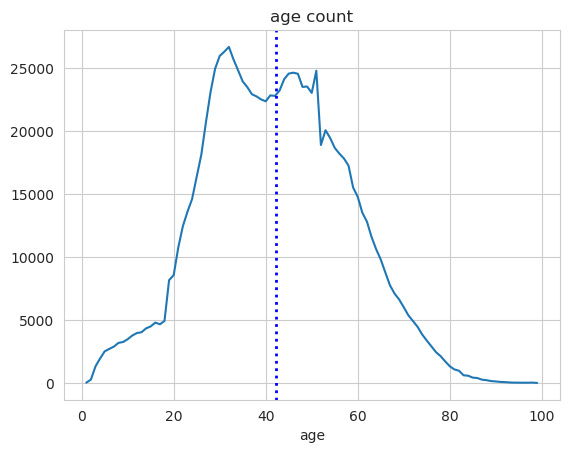

In [61]:
a = df_features_churn.groupby('age')['churn'].count().plot()
plt.title('age count')
plt.axvline(x=np.mean(df_features_churn['age']), color='b', label='mean age', ls=':', lw=2)
plt.show()
fig = a.get_figure()
fig.savefig('../plots/age_clients.png')

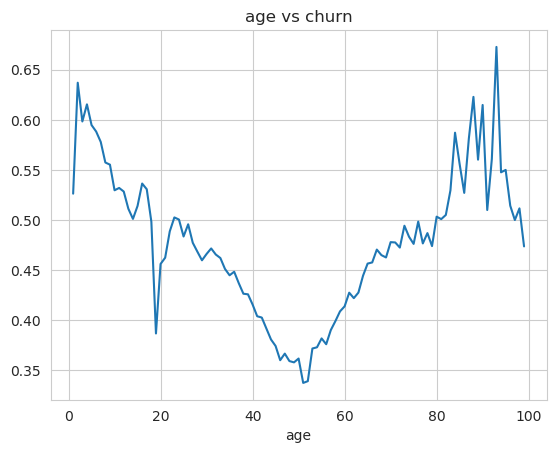

In [62]:
a = df_features_churn.groupby('age')['churn'].mean().plot()
plt.title('age vs churn')
plt.show()
fig = a.get_figure()
fig.savefig('../plots/age_churn.png')

Extract type: Growers, Mantainers, Lowers

Extract value: Low, Mid, High

In [6]:
flag_anc = True
df_features_churn['type'] = df_features_churn.apply(lambda row: compare_years_transf(row, 0.5, 'gross_revenue_future', 'gross_revenue_and_ancillaries_year1'), axis=1)
df_features_churn['value'] = df_features_churn.apply(lambda row: extract_value_customer(row, 'gross_revenue_and_ancillaries_year1'), axis=1)

#### EDA

Churners

In [21]:
df_features_churn_gpby = df_features_churn.groupby('churn')['frequency'].count().reset_index().replace({0: 'No Churn', 1: 'Churn'})

In [22]:
len(df_features_churn)

2006946

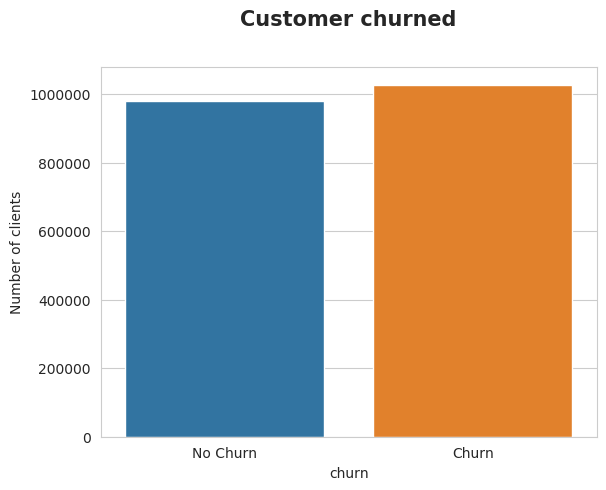

In [23]:
sns.set_style('whitegrid')
ax = sns.barplot(x=df_features_churn_gpby['churn'], y=df_features_churn_gpby['frequency'])
plt.title('Customer churned', pad=30, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()
fig = ax.get_figure()
fig.savefig('../plots/churn_vs_nochurn.png')

Seniority vs last_purchase vs last_flight

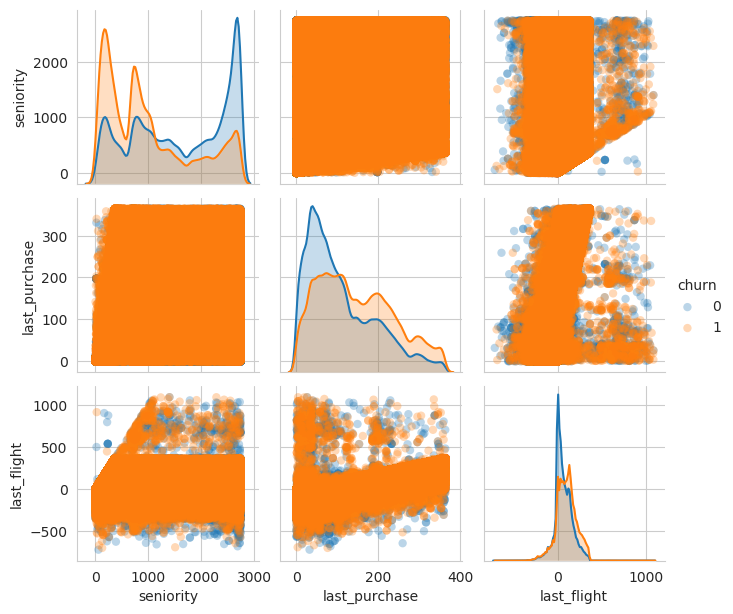

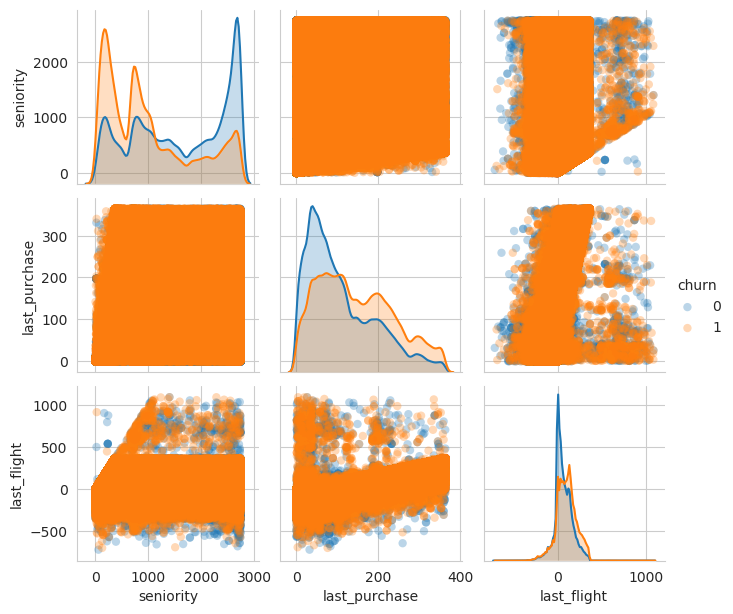

In [17]:
sns.pairplot(df_features_churn[['seniority', 'last_purchase', 'last_flight', 'churn']], hue='churn', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)
plt.show()

MKT Permission

In [18]:
df_features_churn['mkt_permission'] = df_features_churn['mkt_permission'].astype(int)

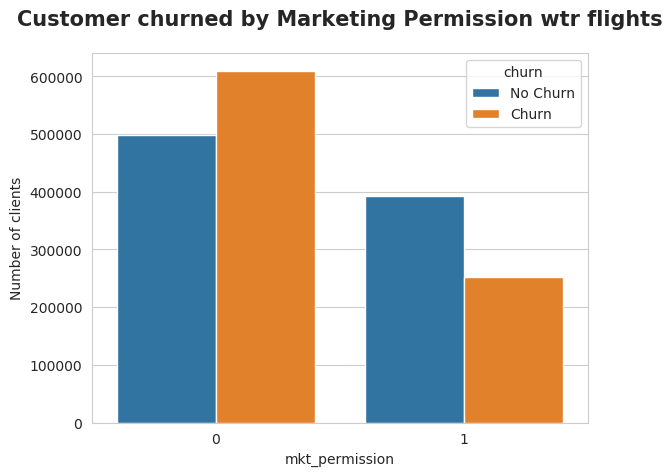

In [19]:
field = 'mkt_permission'
bin_field = 'mkt_permission'
df_features_churn_gpby = df_features_churn.groupby(['churn', bin_field])['frequency'].count().reset_index()
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby[bin_field], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by Marketing Permission wtr flights', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

IBPlus

In [20]:
df_features_churn_gpby = df_features_churn.groupby(['churn', 'ff_tier'])['frequency'].count().reset_index().replace({0: 'No Churn', 1: 'Churn'})
df_features_churn_gpby = df_features_churn_gpby[df_features_churn_gpby['ff_tier'].astype(int) < 4]

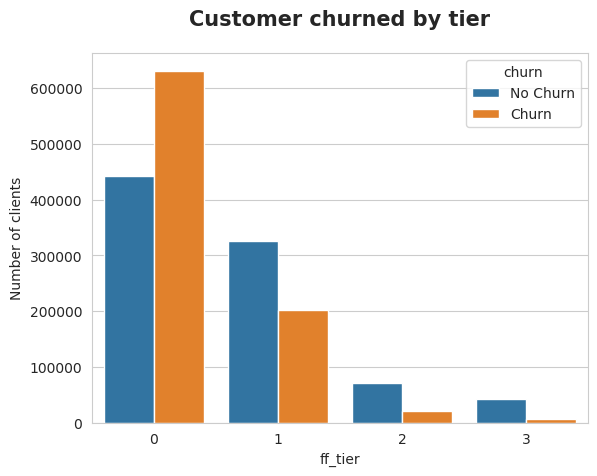

In [23]:
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby['ff_tier'], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by tier', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

Business/Leisure

In [25]:
df_features_churn['bin_ind_reason_business'] = df_features_churn['ind_reason_business'].apply(lambda x: 1 if x > 0.5 else 0)

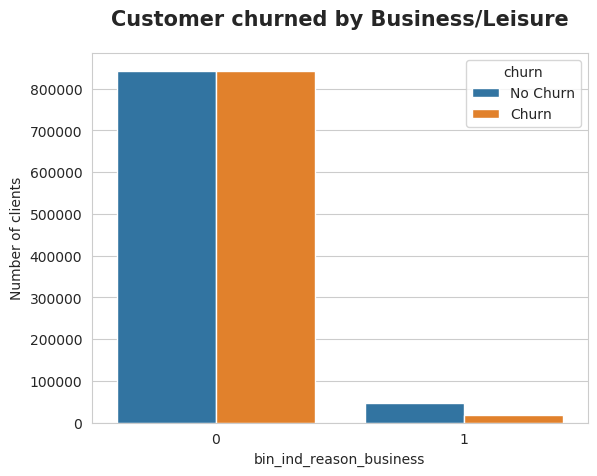

In [28]:
df_features_churn_gpby = df_features_churn.groupby(['churn', 'bin_ind_reason_business'])['frequency'].count().reset_index()
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby['bin_ind_reason_business'], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by Business/Leisure', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

OneWay flights

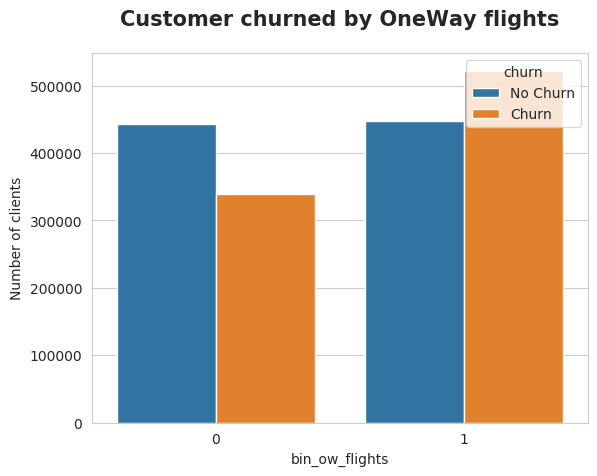

In [29]:
df_features_churn['bin_ow_flights'] = df_features_churn['ow_flights'].apply(lambda x: 1 if x > 0.4 else 0)
df_features_churn_gpby = df_features_churn.groupby(['churn', 'bin_ow_flights'])['frequency'].count().reset_index()
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby['bin_ow_flights'], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by OneWay flights', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

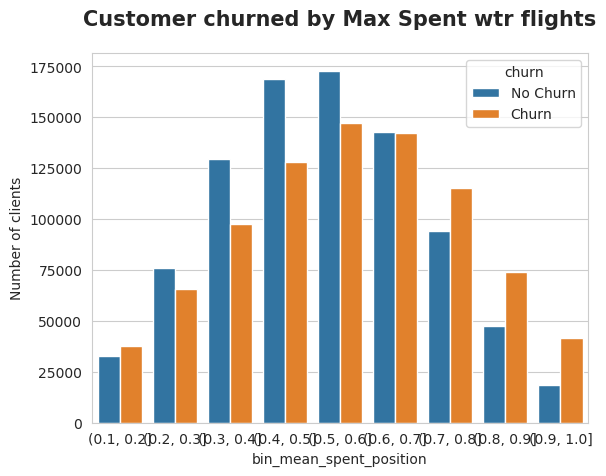

In [30]:
bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
field = 'mean_spent_position'
bin_field = 'bin_' + field
df_features_churn[bin_field] = pd.cut(df_features_churn[field], bins=bins)
df_features_churn_gpby = df_features_churn.groupby(['churn', bin_field])['frequency'].count().reset_index()
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby[bin_field], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by Max Spent wtr flights', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

Target plot

In [31]:
bins = [-1, 0,100,200,300,400,500,700,1000,1500,
      2000,3000,5000,7000,10000]
df_target_bin = pd.cut(df_features_churn['gross_revenue_future'], bins=bins).value_counts()

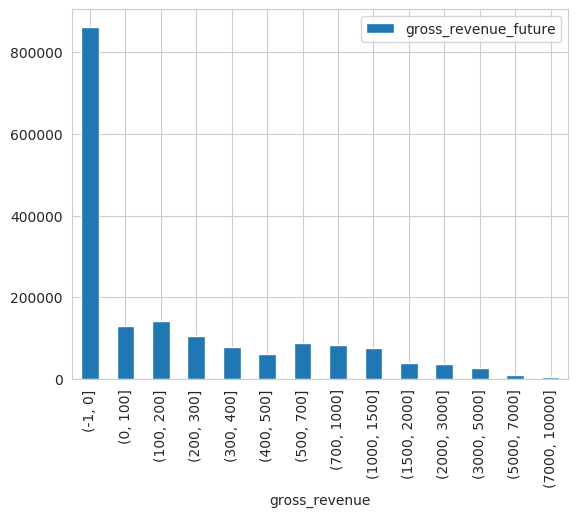

In [34]:
df_target_bin.reset_index().sort_values(by=['index']).rename(columns={'index': 'gross_revenue'}).plot.bar(x='gross_revenue')
plt.show()

In [35]:
df_features_churn_gpby = df_features_churn.groupby(['churn', 'value'])['frequency'].count().reset_index().sort_values(by=['frequency'], ascending=False)
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby['value'], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by CLTV-1', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

KeyError: 'value'

Disruptions

Text(0, 0.5, 'Number of clients')

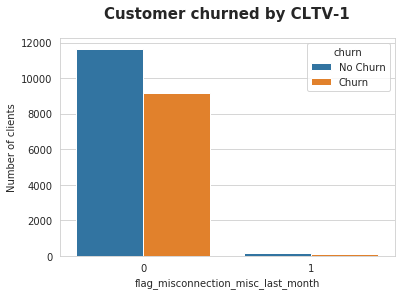

In [27]:
field = 'flag_misconnection_misc_last_month'
df_features_churn_gpby = df_features_churn_dis.groupby(['churn', field])['frequency'].count().reset_index().sort_values(by=['frequency'], ascending=False)
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby[field], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by CLTV-1', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')

In [22]:
df_features_churn_gpby

,churn,num_disrupt_last_3month,frequency
6,Churn,0,572172
0,No Churn,0,439257
1,No Churn,1,7176
7,Churn,1,3362
2,No Churn,2,649
8,Churn,2,350
3,No Churn,3,36
9,Churn,3,13
4,No Churn,4,5
10,Churn,4,2


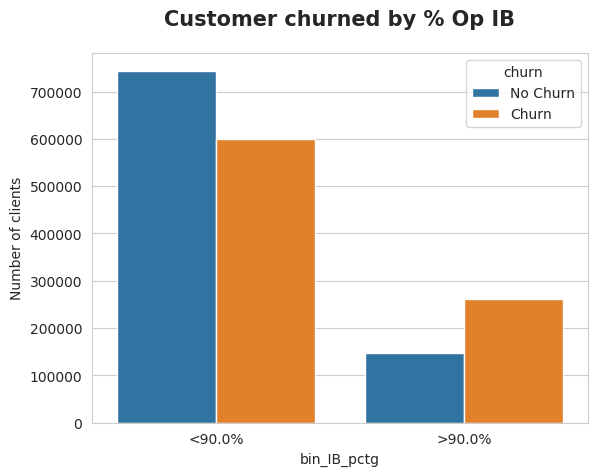

In [40]:
thr = 0.9
df_features_churn['bin_IB_pctg'] = df_features_churn['IB_pctg'].apply(lambda x: '>' + str(thr*100) + '%' if x > thr else '<' + str(thr*100) + '%')
df_features_churn_gpby = df_features_churn.groupby(['churn', 'bin_IB_pctg'])['frequency'].count().reset_index()
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby['bin_IB_pctg'], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by % Op IB', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

In [36]:
df_features_churn

,cid_analytical,frequency,gross_revenue_eur,n_ancillaries,eur_ancillaries,num_days_anticipation,num_hours_in_destination,ind_reason_business,loc_dep_weekend,ow_flights,num_bags,num_seats,num_upgs,num_others,eur_bags,eur_seats,eur_upgs,eur_others,gross_revenue_and_ancillaries,gross_revenue_and_ancillaries_year3,gross_revenue_and_ancillaries_year2,gross_revenue_and_ancillaries_year1,frequency_year3,frequency_year2,frequency_year1,flag_ibplus,pax_type_ind,age,alone_flights,couple_flights,group_flights,summer_flights,winter_flights,fall_flights,spring_flights,seniority,last_purchase,last2_purchase,last3_purchase,last_flight,sh_haul,mh_haul,lh_haul,economy,premium,business,ff_tier,smooth_flying,frugal_first,buss_on_budget,classy_business,leisure_indulgence,global_getaway,frugal_fun,mean_deviation_flight_spent,min_dev_spent_flight,max_dev_spent_flight,mean_spent_position,max_spent_position,min_spent_position,max_minutes_delay_arr_year1,mkt_permission,n_exchanges,n_not_travelled,n_refunded,purchases_2015,purchases_2016,purchases_2017,od_distinct,most_od_bought,most_od_flown,ind_direct_sale,gross_revenue_and_ancillaries_year1_q1,gross_revenue_and_ancillaries_year1_q2,gross_revenue_and_ancillaries_year1_q3,gross_revenue_and_ancillaries_year1_q4,last_spent,n_destination_city_od,is_corporate,revenue_avios,flag_misconnection_misc_last_week,flag_dng_last_week,flight_cnld_last_week,flight_delay_last_week,IB_pctg,is_resident,gross_revenue_future,mean_spend,mean_spend_year3,mean_spend_year2,mean_spend_year1,churn,bin_ind_reason_business,bin_ow_flights,bin_mean_spent_position
cid_analytical,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34062234,34062234,25,2208.620,1,50.000,4.760,65.005,NaN,0.133,0.800,0,0,0,1,0.000,0.000,0.000,50.000,2258.620,1758.150,500.470,0.000,21,3,1,1,C,37.000,0.960,0.040,0.000,0.400,0.160,0.440,0.000,2702.000,103,710.000,716.000,97.000,0.920,0.080,0.000,1.000,0.000,0.000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.209,-1.000,1.626,0.394,1.000,0.031,0.000,1,0,3,1,1,1,9,6,0.680,BCN,0.160,0.000,0.000,0.000,0.000,0.000,5,0.520,13750.000,0,0,0,0,0.903,0,0.000,90.345,83.721,166.823,0.000,1,0,1,"(0.3, 0.4]"
27356037,27356037,2,210.000,0,0.000,64.000,148.458,NaN,0.500,0.000,0,0,0,0,0.000,0.000,0.000,0.000,210.000,86.000,0.000,124.000,1,0,1,1,C,10.000,0.000,0.000,1.000,0.500,0.500,0.000,0.000,1133.000,77,912.000,NaN,-2.000,0.000,1.000,0.000,1.000,0.000,0.000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.579,NaN,0.650,0.784,0.525,NaN,0,0,2,0,0,0,0,2,0.500,MAD,1.000,124.000,0.000,0.000,0.000,124.000,3,0.000,NaN,0,0,0,0,0.250,0,105.000,105.000,86.000,0.000,124.000,0,0,0,"(0.6, 0.7]"
25654475,25654475,2,206.000,0,0.000,17.500,557.500,NaN,0.667,0.500,0,0,0,0,0.000,0.000,0.000,0.000,206.000,0.000,0.000,206.000,0,0,2,0,A,43.000,0.500,0.500,0.000,0.000,0.000,0.000,1.000,265.000,223,265.000,NaN,208.000,0.000,0.000,1.000,1.000,0.000,0.000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.382,-0.622,-0.250,0.658,0.846,0.556,5.000,0,0,1,0,0,0,0,2,0.500,LIM,0.000,0.000,50.000,156.000,0.000,50.000,2,0.000,0.000,0,0,0,0,0.500,0,133.000,103.000,0.000,0.000,103.000,0,0,1,"(0.6, 0.7]"
28350358,28350358,2,1055.320,2,40.450,37.000,532.583,NaN,0.667,0.500,0,2,0,0,0.000,40.450,0.000,0.000,1095.770,0.000,0.000,1095.770,0,0,2,1,A,32.000,1.000,0.000,0.000,0.500,0.000,0.500,0.000,194.000,77,193.000,NaN,27.000,0.000,0.000,1.000,1.000,0.000,0.000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357,-0.149,1.263,0.591,0.680,0.468,-7.000,0,0,0,0,0,0,0,2,0.500,BUE,1.000,942.000,153.770,0.000,0.000,942.000,2,0.000,0.000,0,0,0,0,0.800,0,0.000,547.885,0.000,0.000,547.885,1,0,1,"(0.5, 0.6]"
22554370,22554370,2,90.440,2,79.260,126.500,NaN,0.000,0.500,1.000,2,0,0,0,79.260,0.000,0.000,0.000,169.700,0.000,0.000,169.700,0,0,2,0,A,NaN,0.000,0.000,1.000,0.000,1.000,0.000,0.000,54.000,55,NaN,NaN,-73.000,0.000,1.000,0.000,1.000,0.000,0.000,0,0.000,1.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.948,0.970,0.926,-1.000,1,0,0,0,0,0,0,2,0.500,STO,0.000,169.700,0.000,0.000,0.000,

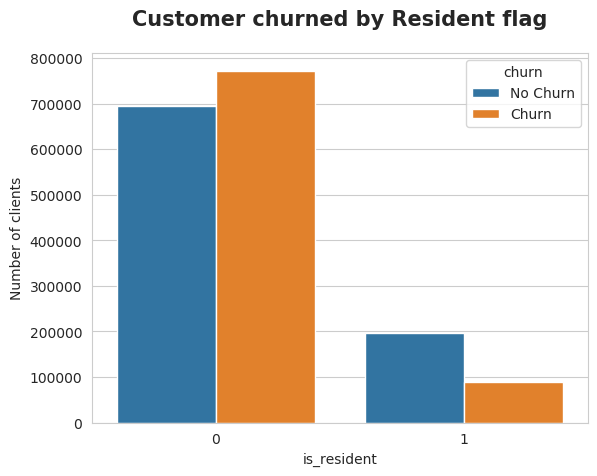

In [41]:
df_features_churn_gpby = df_features_churn.groupby(['churn', 'is_resident'])['frequency'].count().reset_index()
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby['is_resident'], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by Resident flag', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

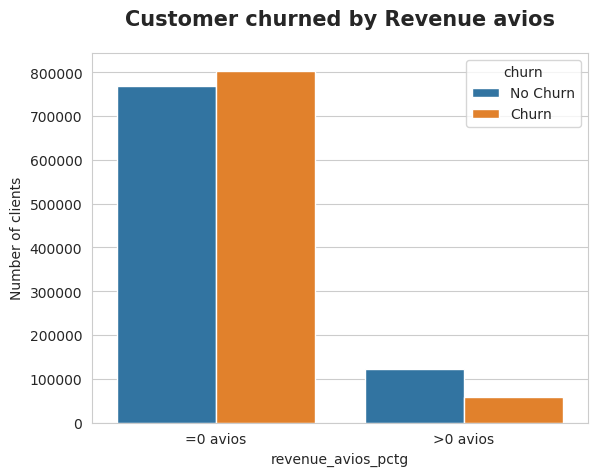

In [42]:
thr = 0
df_features_churn['revenue_avios_pctg'] = df_features_churn['revenue_avios'].apply(lambda x: '>' + str(thr) + ' avios' if x > thr else '=' + str(thr) + ' avios')
df_features_churn_gpby = df_features_churn.groupby(['churn', 'revenue_avios_pctg'])['frequency'].count().reset_index()
df_features_churn_gpby['churn'] = df_features_churn_gpby['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.set_style('whitegrid')
sns.barplot(x=df_features_churn_gpby['revenue_avios_pctg'], y=df_features_churn_gpby['frequency'], hue=df_features_churn_gpby['churn'])
plt.title('Customer churned by Revenue avios', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of clients')
plt.show()

In [47]:
df_features_churn

,cid_analytical,frequency,gross_revenue_eur,n_ancillaries,eur_ancillaries,num_days_anticipation,num_hours_in_destination,ind_reason_business,loc_dep_weekend,ow_flights,num_bags,num_seats,num_upgs,num_others,eur_bags,eur_seats,eur_upgs,eur_others,gross_revenue_and_ancillaries,gross_revenue_and_ancillaries_year3,gross_revenue_and_ancillaries_year2,gross_revenue_and_ancillaries_year1,frequency_year3,frequency_year2,frequency_year1,flag_ibplus,pax_type_ind,age,alone_flights,couple_flights,group_flights,summer_flights,winter_flights,fall_flights,spring_flights,seniority,last_purchase,last2_purchase,last3_purchase,last_flight,sh_haul,mh_haul,lh_haul,economy,premium,business,ff_tier,smooth_flying,frugal_first,buss_on_budget,classy_business,leisure_indulgence,global_getaway,frugal_fun,mean_deviation_flight_spent,min_dev_spent_flight,max_dev_spent_flight,mean_spent_position,max_spent_position,min_spent_position,max_minutes_delay_arr_year1,mkt_permission,n_exchanges,n_not_travelled,n_refunded,purchases_2015,purchases_2016,purchases_2017,od_distinct,most_od_bought,most_od_flown,ind_direct_sale,gross_revenue_and_ancillaries_year1_q1,gross_revenue_and_ancillaries_year1_q2,gross_revenue_and_ancillaries_year1_q3,gross_revenue_and_ancillaries_year1_q4,last_spent,n_destination_city_od,is_corporate,revenue_avios,flag_misconnection_misc_last_week,flag_dng_last_week,flight_cnld_last_week,flight_delay_last_week,IB_pctg,is_resident,gross_revenue_future,mean_spend,mean_spend_year3,mean_spend_year2,mean_spend_year1,churn,bin_ind_reason_business,bin_ow_flights,bin_mean_spent_position,bin_IB_pctg,revenue_avios_pctg
cid_analytical,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34062234,34062234,25,2208.620,1,50.000,4.760,65.005,NaN,0.133,0.800,0,0,0,1,0.000,0.000,0.000,50.000,2258.620,1758.150,500.470,0.000,21,3,1,1,C,37.000,0.960,0.040,0.000,0.400,0.160,0.440,0.000,2702.000,103,710.000,716.000,97.000,0.920,0.080,0.000,1.000,0.000,0.000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.209,-1.000,1.626,0.394,1.000,0.031,0.000,1,0,3,1,1,1,9,6,0.680,BCN,0.160,0.000,0.000,0.000,0.000,0.000,5,0.520,13750.000,0,0,0,0,0.903,0,0.000,90.345,83.721,166.823,0.000,1,0,1,"(0.3, 0.4]",>90.0%,>0 avios
27356037,27356037,2,210.000,0,0.000,64.000,148.458,NaN,0.500,0.000,0,0,0,0,0.000,0.000,0.000,0.000,210.000,86.000,0.000,124.000,1,0,1,1,C,10.000,0.000,0.000,1.000,0.500,0.500,0.000,0.000,1133.000,77,912.000,NaN,-2.000,0.000,1.000,0.000,1.000,0.000,0.000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.579,NaN,0.650,0.784,0.525,NaN,0,0,2,0,0,0,0,2,0.500,MAD,1.000,124.000,0.000,0.000,0.000,124.000,3,0.000,NaN,0,0,0,0,0.250,0,105.000,105.000,86.000,0.000,124.000,0,0,0,"(0.6, 0.7]",<90.0%,=0 avios
25654475,25654475,2,206.000,0,0.000,17.500,557.500,NaN,0.667,0.500,0,0,0,0,0.000,0.000,0.000,0.000,206.000,0.000,0.000,206.000,0,0,2,0,A,43.000,0.500,0.500,0.000,0.000,0.000,0.000,1.000,265.000,223,265.000,NaN,208.000,0.000,0.000,1.000,1.000,0.000,0.000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.382,-0.622,-0.250,0.658,0.846,0.556,5.000,0,0,1,0,0,0,0,2,0.500,LIM,0.000,0.000,50.000,156.000,0.000,50.000,2,0.000,0.000,0,0,0,0,0.500,0,133.000,103.000,0.000,0.000,103.000,0,0,1,"(0.6, 0.7]",<90.0%,=0 avios
28350358,28350358,2,1055.320,2,40.450,37.000,532.583,NaN,0.667,0.500,0,2,0,0,0.000,40.450,0.000,0.000,1095.770,0.000,0.000,1095.770,0,0,2,1,A,32.000,1.000,0.000,0.000,0.500,0.000,0.500,0.000,194.000,77,193.000,NaN,27.000,0.000,0.000,1.000,1.000,0.000,0.000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357,-0.149,1.263,0.591,0.680,0.468,-7.000,0,0,0,0,0,0,0,2,0.500,BUE,1.000,942.000,153.770,0.000,0.000,942.000,2,0.000,0.000,0,0,0,0,0.800,0,0.000,547.885,0.000,0.000,547.885,1,0,1,"(0.5, 0.6]",<90.0%,=0 avios
22554370,22554370,2,90.440,2,79.260,126.500,NaN,0.000,0.500,1.000,2,0,0,0,79.260,0.000,0.000,0.000,169.700,0.000,0.000,169.700,0,0,2,0,A,NaN,0.000,0.000,1.000,0.000,1.000,0.000,0.000,54.000,55,NaN,NaN,-73.000,0.000,1.000,0.000,1.000,0.000,0.000,0,0.000,1.000,0.000,0.000,0.000,0.000,0.00

Variables a eliminar:

renombrar business --> ind_business_economy

dejar gross_revenue_and_ancillaries, dejar trend pero quitar los years1,2,3

- ind_reason_business de momento fuera

- variables demand spaces fuera

- dejar frequency, dejar trend pero quitar los frequency1,2,3

- dejar ancillaries generales y eliminar las individuales

- eliminar mean spent position

- quitar las variables de q's

- od distinct quitar

- gross_revenue_eur fuera

- max_spent_position fuera

- min_dev_spent_flight fuera

sh haul y mh haul correlarlas

In [17]:
df_corr = matrix.stack().reset_index()
df_corr = df_corr[df_corr['level_0'] != df_corr['level_1']]
df_corr['absolute_corr'] = abs(df_corr[0])
df_corr.sort_values(by='absolute_corr', ascending=False)[100:150]

,level_0,level_1,0,absolute_corr
1837,frequency_year1,gross_revenue_and_ancillaries_year1,0.580,0.580
1603,gross_revenue_and_ancillaries_year1,frequency_year1,0.580,0.580
248,eur_ancillaries,num_upgs,0.580,0.580
70,frequency,n_destination_city_od,0.580,0.580
872,num_upgs,eur_ancillaries,0.580,0.580
5530,n_destination_city_od,frequency,0.580,0.580
5516,last_spent,gross_revenue_and_ancillaries_year1_q1,0.570,0.570
5204,gross_revenue_and_ancillaries_year1_q1,last_spent,0.570,0.570
4084,mean_deviation_flight_spent,max_spent_position,-0.560,0.560
4396,max_spent_position,mean_deviation_flight_spent,-0.560,0.560


In [8]:
matrix = df_features_churn[df_features_churn.columns[:-6]].corr().round(2)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(matrix, linewidths=.5, ax=ax)
#plt.show()